# 03 - Features Core

## Objetivo
- Crear features base de vivienda y geografia sin leakage.
- Generar transformaciones log y densidades locales OOF.
- Dataset listo para baselines y boosting.

## Flujo general
- Cargar `artifacts/processed_rent.*`.
- Crear geohash, distancia al centro y logs.
- Calcular densidad local OOF (train) y train-only para holdout.
- Guardar `artifacts/features_core.*`.

## Inputs esperados
- `artifacts/processed_rent.csv.gz`
- `artifacts/splits/holdout_indices.npz`

## Outputs/artefactos
- `artifacts/features_core.csv.gz`


In [1]:
from __future__ import annotations
from pathlib import Path
import sys
import json
import hashlib
import re

import numpy as np
import pandas as pd

# --- Base setup y reproducibilidad ---
SEED = 42
np.random.seed(SEED)


def get_repo_root() -> Path:
    """Return repo root by walking parents and checking .git/pyproject.toml."""
    current = Path.cwd().resolve()
    for parent in [current] + list(current.parents):
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return current

ROOT = get_repo_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))


In [2]:
from sklearn.neighbors import BallTree
from sklearn.model_selection import KFold
from src.utils import haversine, spatial_group

# --- Cargar dataset procesado ---
processed_path = ROOT / "artifacts" / "processed_rent.parquet"
if processed_path.exists():
    rent_df = pd.read_parquet(processed_path)
else:
    rent_df = pd.read_csv(ROOT / "artifacts" / "processed_rent.csv.gz")

# Detectar columnas lat/lon
lat_col = next((c for c in rent_df.columns if "lat" in c.lower()), None)
lon_col = next((c for c in rent_df.columns if "lon" in c.lower() or "lng" in c.lower()), None)

# Geohash y distancia al centro (si hay coordenadas)
if lat_col and lon_col:
    lat_series = pd.to_numeric(rent_df[lat_col], errors="coerce")
    lon_series = pd.to_numeric(rent_df[lon_col], errors="coerce")
    rent_df["geohash_6"] = spatial_group(rent_df, lat_col, lon_col, precision=6)
    rent_df["distance_center_km"] = [
        haversine(40.4168, -3.7038, lat, lon)
        if not (np.isnan(lat) or np.isnan(lon))
        else np.nan
        for lat, lon in zip(lat_series.to_numpy(), lon_series.to_numpy())
    ]

# Log transforms
for col in ["price", "price_m2", "surface_m2"]:
    if col in rent_df.columns:
        rent_df[f"log_{col}"] = np.log1p(rent_df[col])

# Densidad local (OOF en train, train-only para holdout)
if lat_col and lon_col:
    split_path = ROOT / "artifacts" / "splits" / "holdout_indices.npz"
    split = np.load(split_path) if split_path.exists() else None
    if split is None:
        raise FileNotFoundError("Falta artifacts/splits/holdout_indices.npz para densidades OOF.")
    train_idx = split["train_idx"]
    test_idx = split["test_idx"]
    lat_series = pd.to_numeric(rent_df[lat_col], errors="coerce")
    lon_series = pd.to_numeric(rent_df[lon_col], errors="coerce")
    valid_mask = lat_series.notna() & lon_series.notna()
    rent_df["density_1km"] = np.nan

    coords_all = np.radians(rent_df[[lat_col, lon_col]].to_numpy())
    positions = np.arange(len(rent_df))
    train_mask = np.isin(positions, train_idx)
    train_positions = positions[train_mask & valid_mask.to_numpy()]
    holdout_positions = positions[~train_mask & valid_mask.to_numpy()]

    radius = 1 / 6371  # 1 km en radianes
    if len(train_positions) > 0:
        kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
        for tr_pos_idx, val_pos_idx in kf.split(train_positions):
            tr_positions = train_positions[tr_pos_idx]
            val_positions = train_positions[val_pos_idx]
            tree = BallTree(coords_all[tr_positions], metric="haversine")
            counts = tree.query_radius(coords_all[val_positions], r=radius, count_only=True)
            rent_df.loc[val_positions, "density_1km"] = counts

        if len(holdout_positions) > 0:
            tree = BallTree(coords_all[train_positions], metric="haversine")
            counts = tree.query_radius(coords_all[holdout_positions], r=radius, count_only=True)
            rent_df.loc[holdout_positions, "density_1km"] = counts


In [3]:
# Ratios adicionales
if "price" in rent_df.columns and "surface_m2" in rent_df.columns:
    # Evita division por cero usando surface_m2 como fallback si no hay rooms
    rent_df["price_per_room"] = rent_df["price"] / rent_df.get("rooms", rent_df["surface_m2"])

# Guardar features core
features_path = ROOT / "artifacts" / "features_core.parquet"
try:
    rent_df.to_parquet(features_path, index=False)
except Exception:
    rent_df.to_csv(ROOT / "artifacts" / "features_core.csv.gz", index=False, compression="gzip")


**Outputs esperados**
- Nuevas columnas: `geohash_6`, `distance_center_km`, `log_price`, `log_price_m2`, `density_1km`.
- Archivo `artifacts/features_core.*` con features numericas listas para modelos.


### Visualizaciones de features
- Scatter price vs distance_center_km.
- Heatmap de correlaciones numericas.


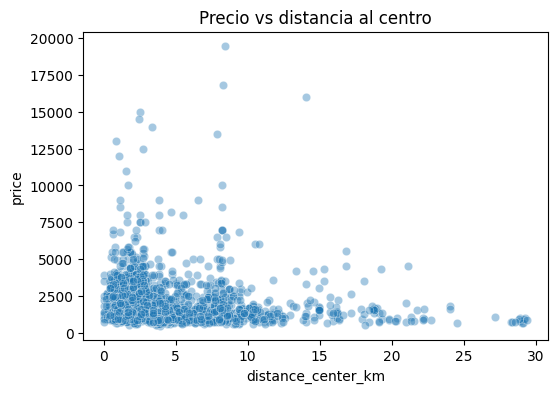

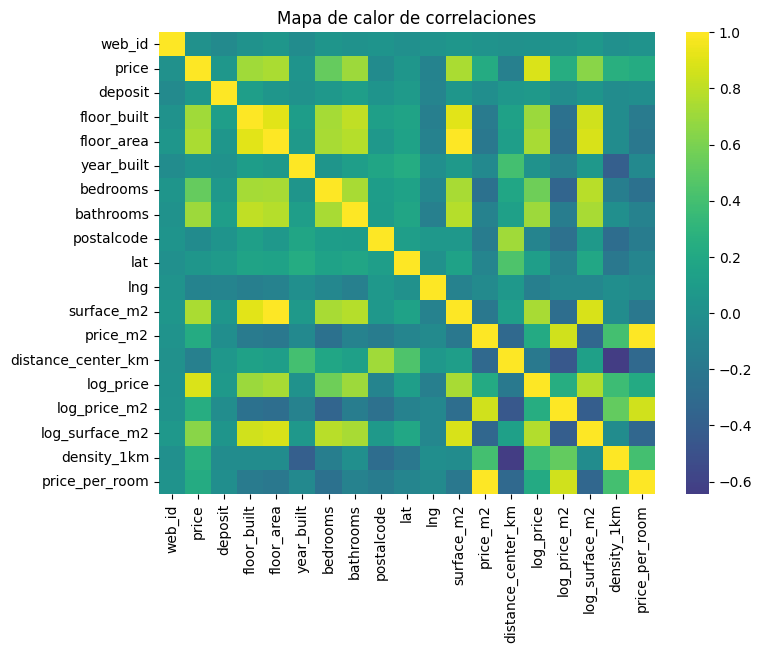

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Relacion precio vs distancia al centro
if "distance_center_km" in rent_df.columns and "price" in rent_df.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=rent_df.sample(min(2000, len(rent_df)), random_state=SEED),
        x="distance_center_km",
        y="price",
        alpha=0.4,
    )
    plt.title("Precio vs distancia al centro")
    plt.show()

# Mapa de calor de correlaciones
numeric = rent_df.select_dtypes(include=["number"])
if not numeric.empty:
    corr = numeric.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap="viridis", center=0)
    plt.title("Mapa de calor de correlaciones")
    plt.show()
